#### Analysis of muscimol data
Data needs to be grouped using 'Bpod_Analysis_MergeAnimals' before

In [266]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
# path to the dataset
data_directory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/Muscimol_Analysis/'
# dataframe name
df_name = 'Muscimol_dataframe.pkl'

# Read the dataframe
AnimalsDF = pd.read_pickle(data_directory + df_name)

In [268]:
# name your dataset for plotting
df_to_plot = AnimalsDF

Progress: [####################] 100.0%


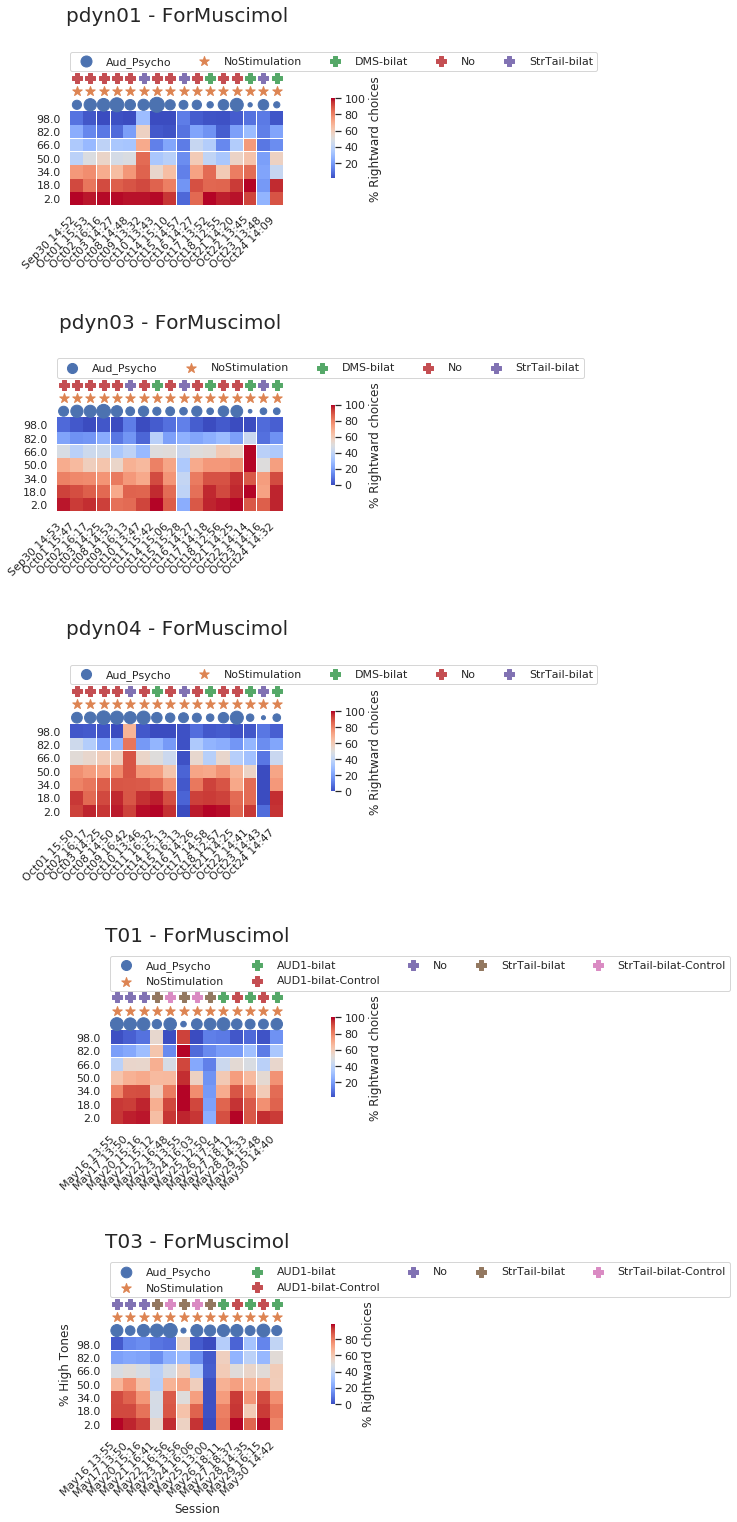

In [279]:
# plot a summary of all the animals in the dataset
fig, ax = plt.subplots(len(pd.unique(df_to_plot.AnimalID)), 1, figsize=(17,5 * len(pd.unique(df_to_plot.AnimalID))))
axs = ax.ravel()
fig.subplots_adjust(hspace=1.3)
for i, animal in enumerate(pd.unique(df_to_plot.AnimalID)):
    aDF = df_to_plot[df_to_plot.AnimalID == animal]
    dfToPlot = plot_utils.summary_matrix(aDF)
    axs[i] = plot_utils.summary_plot(dfToPlot, aDF, axs[i])
plt.savefig(data_directory + 'psychometricPerformanceSessionsAnalyzedHeatmap.pdf', transparent=True, bbox_inches='tight')    
plt.show(fig)

In [270]:
#Select conditions

# remove the trials at the beginning of the session
condition4 = AnimalsDF['TrialIndex'] > 10
conditions = condition4

# select only some protocols
prot_to_select = ['Aud_Psycho']
condition6 = AnimalsDF.Protocol.isin(prot_to_select)
conditions = np.logical_and(conditions, condition6)

df_to_plot = AnimalsDF[conditions]

In [271]:
# select particular sessions to remove:
sessionIDs_toremove = ['T01 Mar19 15:24', 'T01 Mar20 14:37', 'T01 Mar21 14:48',
       'T01 Mar22 13:32', 'T01 Mar22 13:52', 'T01 Mar25 14:40',
       'T01 Mar26 17:14', 'T01 Mar27 14:04', 'T01 Mar27 14:23',
       'T01 Mar28 14:40', 'T01 Apr29 13:13', 'T01 Apr30 15:37',
       'T01 May01 14:42', 'T01 May02 15:02', 'T01 May04 13:31',
       'T01 May06 14:15', 'T01 May09 11:54', 'T01 May10 09:51',
       'T01 May14 14:14','T03 Mar25 14:54', 'T03 Mar26 16:16', 'T03 Mar27 14:04',
       'T03 Mar28 15:14', 'T03 Apr30 15:39', 'T03 May01 14:42',
       'T03 May02 15:02', 'T03 May04 13:30', 'T03 May06 14:14',
       'T03 May07 16:17', 'T03 May07 16:19', 'T03 May09 11:54',
       'T03 May10 09:51']

df_to_plot = df_to_plot[~(df_to_plot['SessionID'].isin(sessionIDs_toremove))]

# Use this to see the session IDs for a particular animal and select the ones you want
#df_to_plot[df_to_plot.AnimalID == 'T03'].SessionID.unique()


In [272]:
# analyze the time they spend per sessions (some of them I have allowed recovery) TODO
# TrialStartTimestamp contains information about the trial time after the start of the session

# restrict the count to 1.5 hours
hours_cut_off = 1.5
df_to_plot = df_to_plot[df_to_plot['TrialStartTimestamp'] < hours_cut_off * 60 * 60]

In [273]:
# types of muscimol
df_to_plot.Muscimol.unique()

array(['No', 'StrTail-bilat', 'NAc', 'DMS-bilat', 'StrTail-bilat-Control',
       'AUD1-bilat', 'AUD1-bilat-Control', 'StrTail-right',
       'StrTail-left'], dtype=object)

In [274]:
# select which types to analyze
muscimol_tokeep = ['No', 'StrTail-bilat', 'DMS-bilat', 'StrTail-bilat-Control', 'AUD1-bilat', 'AUD1-bilat-Control']
df_to_plot = df_to_plot[df_to_plot['Muscimol'].isin(muscimol_tokeep)]

Progress: [####################] 100.0%


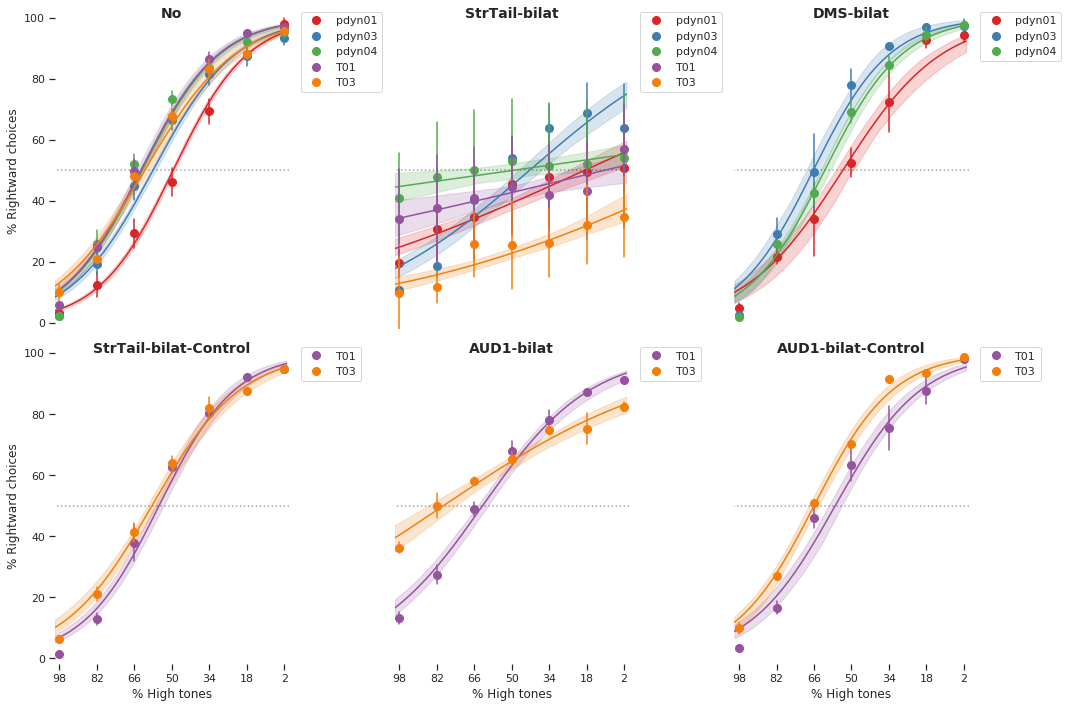

In [275]:
# plot psychometric curves

# prepare colors
my_palette = "Set1"
AnimalList = list(df_to_plot.AnimalID.unique())
ColorList = sns.color_palette(my_palette, n_colors=len(AnimalList), desat=.9)

fig, axs = plt.subplots(2, math.ceil(len(df_to_plot.Muscimol.unique())/2), figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=.2, wspace=2)
axs = axs.ravel()
for ax in axs:
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)

for counter, muscimol_condition in enumerate(df_to_plot.Muscimol.unique()):
    ax = axs[counter]
    ax.text(50, 100, muscimol_condition, horizontalalignment='center', fontsize=14, fontweight='bold')
    for animal in df_to_plot[df_to_plot.Muscimol == muscimol_condition].AnimalID.unique():
        conditions = (df_to_plot['AnimalID'] == animal) & (df_to_plot['Muscimol'] == muscimol_condition)
        predictDif, PsyPer, fakePredictions, predictPer, EB = \
        cuf.PP_ProcessExperiment(df_to_plot[conditions], 50, error_bars='SessionTime')
        plot_utils.PlotPsychPerformance(dataDif=PsyPer['Difficulty'], dataPerf=PsyPer['Performance'],
                                        predictDif=predictDif, ax=ax, fakePred=fakePredictions,
                                        realPred=predictPer, label=animal, errorBars=EB,
                                        color=ColorList[AnimalList.index(animal)])
        
    #ax.get_legend().remove()
    ax.axis('on')
    # remove some ticks
    ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                   labelleft='on', labelbottom='on')
    if not ax.is_first_col():
        ax.set_ylabel('')
        ax.set_yticks([])
    if not ax.is_last_row():
        ax.set_xlabel('')
        ax.set_xticks([])
    plt.tight_layout()

    update_progress(counter / len(df_to_plot.Muscimol.unique()))
    
update_progress(1)
plt.savefig(data_directory + 'psychometricPerformance_byMuscimol.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [276]:
# fit a model to each session, extract the parameters, and compare those

# create empty df
coefs_df = pd.DataFrame(columns=['AnimalID', 'SessionID', 'Muscimol', 'Coef', 'Intercept', 'Cs'])

for session in df_to_plot.SessionID.unique():
    df = df_to_plot[df_to_plot.SessionID == session]
    # calculate the psych
    predictDif, PsyPer, fakePredictions, predictPer, _ = cuf.PP_ProcessExperiment(df, None)

    coefs_df = coefs_df.append({
                                'AnimalID': df.AnimalID.unique()[0],
                                'SessionID': session,
                                'Muscimol': df.Muscimol.unique()[0],
                                'Coef': PsyPer['Logit'].coef_[0][0],
                                'Intercept': PsyPer['Logit'].intercept_[0],
                                'Cs': PsyPer['Logit'].C_[0]
                                }, ignore_index=True)

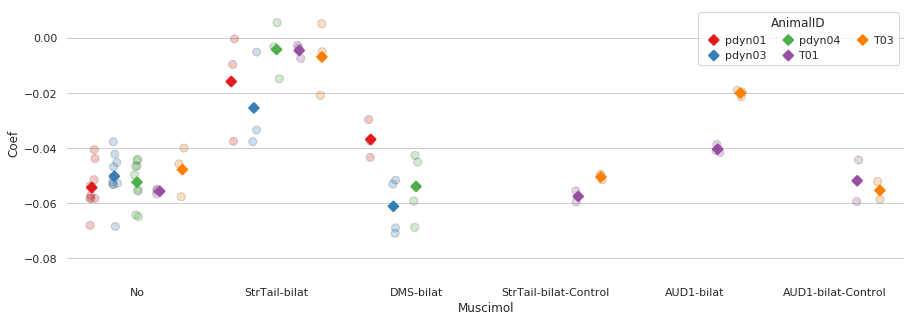

In [277]:
sns.set_style('whitegrid')
# Initialize the figure for only the coeficients
fig, ax = plt.subplots(figsize=(15,5))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="Muscimol", y="Coef", hue="AnimalID",
              data=coefs_df, dodge=True, jitter=True,
              alpha=.25, zorder=1, size=8, palette=my_palette,
              linewidth=1)

# Show the conditional means
sns.pointplot(x="Muscimol", y="Coef", hue="AnimalID",
              data=coefs_df, dodge=.65, join=False, palette=my_palette,
              markers="D", scale=1, ci=None)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[len(AnimalList):], labels[len(AnimalList):], title="AnimalID",
          handletextpad=0, columnspacing=1,
          loc="top right", ncol=3, frameon=True)
plt.savefig(data_directory + 'coefficients_byMuscimol.pdf', transparent=True, bbox_inches='tight')
plt.show()

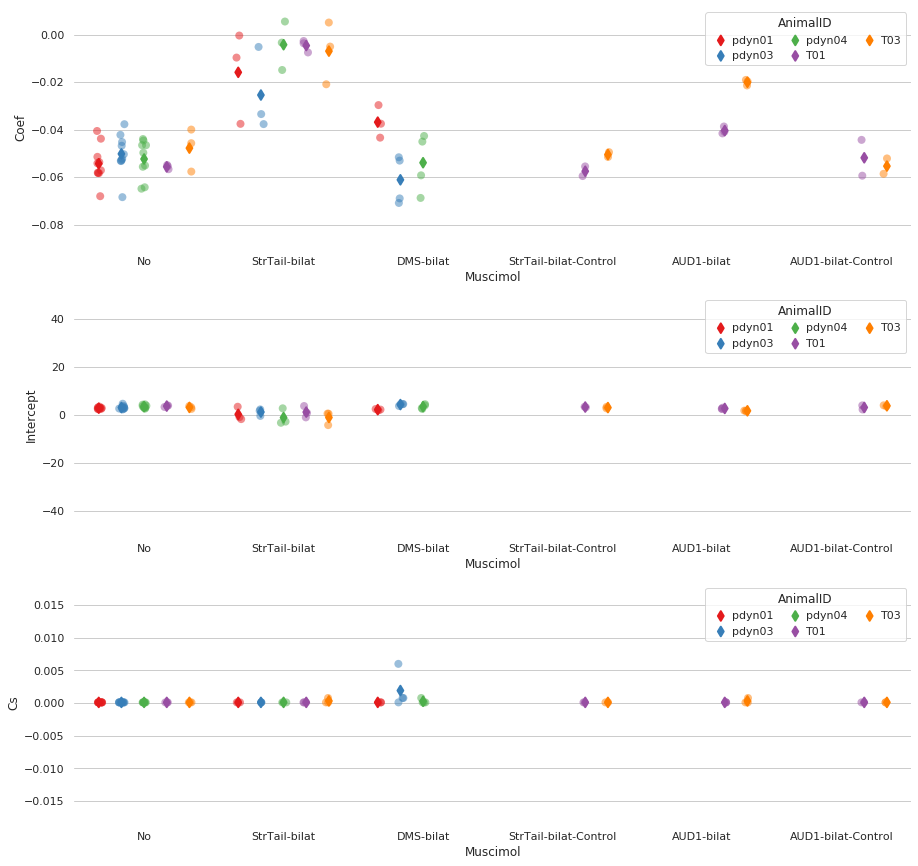

In [278]:
# plot results for all the parameters
# plot this C_s to see if the data needs regularization (if they are small they don't need it)
param_order = ['Coef', 'Intercept', 'Cs']
# Initialize the figure
fig, axs = plt.subplots(len(param_order), 1, figsize=(15, len(param_order) * 5), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace=.2, wspace=2)
axs = axs.ravel()
sns.despine(bottom=True, left=True)

for counter, ax in enumerate(axs):
    #ax.text(50, 100, param_order[counter], horizontalalignment='center', fontsize=14, fontweight='bold')
    # Show each observation with a scatterplot
    sns.stripplot(x="Muscimol", y=param_order[counter], hue="AnimalID",
                  data=coefs_df, dodge=True, jitter=True,
                  alpha=.5, zorder=1, size=8, palette=my_palette, ax=ax)

    # Show the conditional means
    sns.pointplot(x="Muscimol", y=param_order[counter], hue="AnimalID",
                  data=coefs_df, dodge=.65, join=False, palette=my_palette,
                  markers="d", scale=1, ci=None, ax=ax)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[len(AnimalList):], labels[len(AnimalList):], title="AnimalID",
              handletextpad=0, columnspacing=1,
              loc="top right", ncol=3, frameon=True)
axs[1].set_ylim(-50,50)
plt.show()

In [198]:
# explore reaction times, speed, number of trials, pokes in the center, psych curves after good and bad choices, etc
df_to_plot.keys()

Index(['AnimalID', 'ExperimentalGroup', 'SessionTime', 'FullSessionTime',
       'Protocol', 'Stimulation', 'Muscimol', 'CenterPortDuration',
       'Contingency', 'RewardAmount', 'TrialIndex', 'TrialHighPerc',
       'Outcomes', 'OptoStim', 'FirstPokeCorrect', 'FirstPoke', 'TrialSide',
       'TrialSequence', 'ResponseTime', 'TrialStartTimestamp',
       'CumulativePerformance', 'SwitchSide', 'PreviousChoice', 'TrialEvents',
       'TrialStates', 'SessionID', 'CumulativeTrialNumber',
       'CumulativeTrialNumberByProtocol', 'CurrentPastPerformance',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime',
       'RightBias'],
      dtype='object')

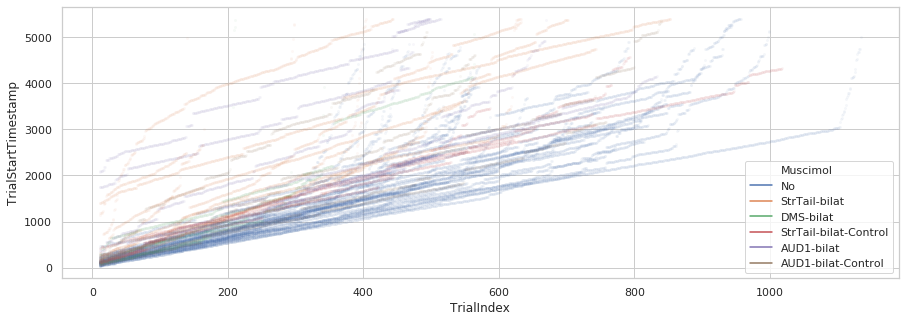

In [207]:
# plot the number of trials per session as a function of time
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialStartTimestamp',
             data=df_to_plot,
             ax=ax, hue='Muscimol', 
             marker=".", alpha=0.05, markeredgewidth=0, linewidth=0,
             # the following line splits the data and does not compute confidence intervals and mean
             units="AnimalID", estimator=None)

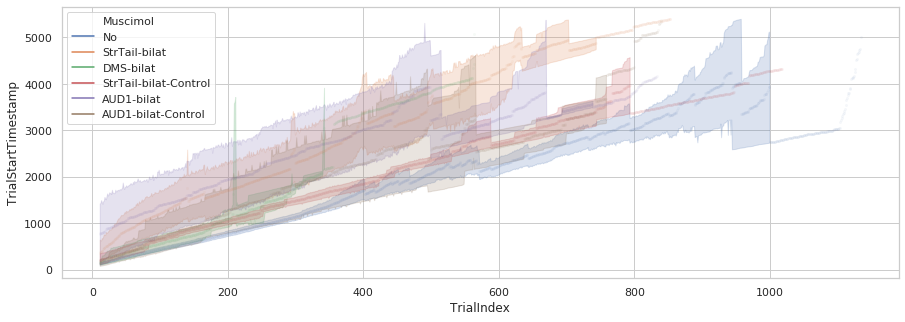

In [204]:
# plot the number of trials per session as a function of time
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialStartTimestamp',
             data=df_to_plot,
             ax=ax, hue='Muscimol', 
             marker=".", alpha=0.05, markeredgewidth=0, linewidth=0)
             # the following line splits the data and does not compute confidence intervals and mean
             #units="AnimalID", estimator=None)

In [260]:
# Calculate speed over the surrounding 20 trials
SP_WINDOW = 20
speed_list = []
for Sid in pd.unique(df_to_plot['SessionID']):
    speed_list.append(cuf.speed_window_calculator(df_to_plot[df_to_plot['SessionID']==Sid], SP_WINDOW))
# flatten the list of lists
df_to_plot['TrialsSpeed'] = np.array(list(chain(*[x for x in speed_list])))

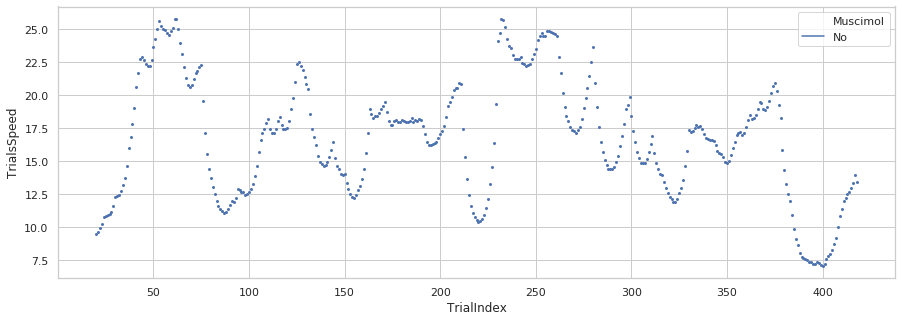

In [263]:
# plot the speed per session as a function of time
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialsSpeed',
             data=df_to_plot[df_to_plot.SessionID==session],
             ax=ax, hue='Muscimol', 
             marker=".", alpha=1, markeredgewidth=0, linewidth=0,
             # the following line splits the data and does not compute confidence intervals and mean
             units="AnimalID", estimator=None)

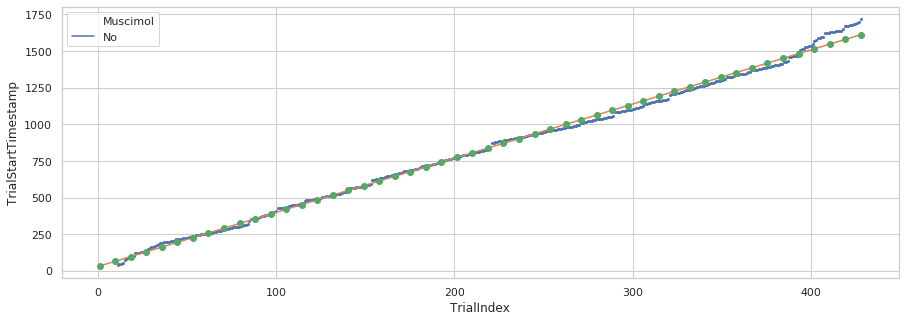

In [230]:
# test of model fitting
session = 'pdyn01 Sep30 14:52'
from sklearn.linear_model import LinearRegression
df = df_to_plot[df_to_plot.SessionID==session]
lrmodel = LinearRegression().fit(df.TrialIndex[:, np.newaxis], df.TrialStartTimestamp)
xvals = np.linspace(1,max(df.TrialIndex), 50)
preds = lrmodel.predict(xvals[:, np.newaxis])

hand_preds = [lrmodel.intercept_ + lrmodel.coef_ * x for x in xvals]

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x='TrialIndex', y='TrialStartTimestamp',
             data=df_to_plot[df_to_plot.SessionID==session],
             ax=ax, hue='Muscimol', 
             marker=".", alpha=1, markeredgewidth=0, linewidth=0,
             # the following line splits the data and does not compute confidence intervals and mean
             units="AnimalID", estimator=None)
plt.plot(xvals,preds)
plt.plot(xvals,hand_preds, 'o')


In [227]:
lrmodel.coef_

array([3.69694017])